In [9]:
"""import sys
path_to_challenge_sncf_2024 = '/Users/gurvanrichardeau/Python_projects/LocalCodes/challenge_sncf_2024'
sys.path.append(path_to_challenge_sncf_2024 + '/utils')"""

from utils.PandasToolsFunction import *
from utils.DataPreprocessingTools import *
from utils.loss_functions import mean_absolute_percentage_error_np

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestRegressor
import joblib
import os

import matplotlib.pyplot as plt

In [10]:
class RegressorModelPytorch():
    
    """
    Split data per stations to not overcharge memory.
    """

    def __init__(self, train_data: pd.DataFrame, model_name:str,
                path_to_device:str, size = 50, 
                regressor_type='RandomForest', n_estimators = 1_000,
                station_col = 'station', features_col = ['week', 'day_numeric', 'day_type'],
                label_col = 'y') -> None:

        self.submission = None
        
        self.size = size 

        self.regressor_type = regressor_type
        self.n_estimators = n_estimators

        self.train_data = train_data
        self.station_col = station_col
        self.features_col = features_col
        self.label_col = label_col

        self.features_dim = len(features_col)

        self.setting_scaler(train_data) # Once and for all.

        # We split the training date per subsets of "size" stations each.
        self.split_dataframes = train_data_station_split(self.train_data, size, station_col)
        self.nb_of_small_data = len(self.split_dataframes)
        
        self.test_scores = {}
        self.train_scores = {}

        # For plot and save
        self.model_name = model_name + f'_n_est_{n_estimators}'
        self.models_saving_path = path_to_device
        self.scores_saving_path = f'models/{regressor_type}/Scores/' + f'n_est_{n_estimators}' 
        self.scores_title = f'{regressor_type}, n_estimators : {n_estimators} \n '
    
    def setting_scaler(self, train_data: pd.DataFrame):
                
        # We need to use only one scaler for every station, we fit on one station and we then reuse it for every other. 
        # Be careful to use the same for testing than for training, indeed, as there are not as many weeks on the test, set, the scaling would be different
        # if it is made on the test.set

        self.scaler = MinMaxScaler()
        # Training the scaler once and for all :

        mask = (train_data['station'] == train_data[self.station_col].unique()[0])
        features = train_data[mask][self.features_col]
        _ = self.scaler.fit_transform(features)

    def preprocessing_data(self, small_train_data: pd.DataFrame, test_size = 0.1, model_to_load = None):

        stations = small_train_data[self.station_col].unique()

        # Creating one model per station. 
        if model_to_load is not None :
            self.load_small_data(model_to_load)
        elif self.regressor_type =='RandomForest' :
            self.models = {station : RandomForestRegressor(n_estimators=self.n_estimators) for station in stations} 
        
        self.datasets = {} # each dataset will contain four sets : X_train, X_test, Y_train, Y_test

        # creating datasets

        for station in stations :

            station_indices = small_train_data.index[small_train_data[self.station_col] == station]
            features = small_train_data.loc[station_indices, self.features_col]
            y = small_train_data.loc[station_indices, self.label_col]
            # print("TYPE Y", type(y)) # pandas.Series
            y = np.array(y)

            X_normalized = self.scaler.transform(features)

            self.datasets[station] = train_test_split(X_normalized, y, test_size=test_size, random_state= 42, shuffle=False)

    def train(self, test_size = 0.1, threshold = 0.1, load_models_until = -1) :
        """ 
        
        load_models_until: Will load previously trained models until the small_train_data number "load_models_until".
        
        When you have trained the Regressor not on every small_train_data and you do not begin again from zero.

        """
        for k, small_train_data in tqdm(enumerate(self.split_dataframes), desc="Split dataframes") :
            
            if k <= load_models_until :
                self.preprocessing_data(small_train_data, test_size, model_to_load=k)
            else : 
                self.preprocessing_data(small_train_data, test_size)
            
            for station, regressor in tqdm(self.models.items(), desc="Stations"):
                
                X_train, X_test, y_train, y_test = self.datasets[station]
                
                regressor.fit(X_train, y_train)
                
                test_pred = regressor.predict(X_test)
                train_pred = regressor.predict(X_train)

                test_score = mean_absolute_percentage_error_np(y_test, test_pred, threshold)
                train_score = mean_absolute_percentage_error_np(y_train, train_pred, threshold)

                print(f'Train data size : {len(X_train)}, Test data size : {len(X_test)}')
                print(f'Score on train set : {train_score}, Score on test set : {test_score}')

                self.test_scores[station] = test_score
                self.train_scores[station] = train_score
                
            self.save_small_data(k)
                
    def test(self, test_data: pd.DataFrame):
        
        # Important to keep same size than for training, that is why we put self.size
        test_split_dataframes = train_data_station_split(test_data, self.size, self.station_col)
 
        for k, small_test_data in enumerate(test_split_dataframes):

            self.load_small_data(k)
            
            for station, regressor in self.models.items() :
                station_indices = small_test_data.index[small_test_data[self.station_col] == station]
                features = small_test_data.loc[station_indices, self.features_col]
                X_test_normalized = self.scaler.transform(features)

                y_pred = regressor.predict(X_test_normalized)
                y_pred = np.maximum(y_pred, 0)
                
                # Update the original DataFrame directly
                test_data.loc[station_indices, self.label_col] = y_pred
                          
        self.submission = test_data[['index', 'y']]
        return test_data
    
    def plot_scores(self, subtitle:str, fig_name = None):
        # Both dictionaries have the same keys
        keys = list(self.test_scores.keys())

        test_values = [self.test_scores[key] for key in keys]
        train_values = [self.train_scores[key] for key in keys]
        test_mean = np.mean(test_values)
        train_mean = np.mean(train_values)
      
        plt.plot(keys, test_values, label='Test Scores')
        plt.plot(keys, train_values, label='Train Scores')
        plt.axhline(test_mean, color='r', linestyle='--', label=f'Mean Test Score: {test_mean}')
        plt.axhline(train_mean, color='b', linestyle='--', label=f'Mean Train Score: {train_mean}')

        plt.xlabel('Keys')
        plt.ylabel('Scores')
        
        plt.title(self.scores_title + subtitle )
        plt.legend()

        if fig_name is not None :
            plt.savefig(self.scores_saving_path + fig_name + '.png')

        plt.show()

    def save_small_data(self, k):
       # Create a directory if it doesn't exist
        os.makedirs(self.models_saving_path + self.model_name, exist_ok=True)
        path_name_of_models_k = self.models_saving_path + self.model_name + f'/models_{k}_out_of_{self.nb_of_small_data - 1}.joblib'
        joblib.dump(self.models, path_name_of_models_k)
        print(f"Models for small_train_data {k} have been saved successfully into path : \n {path_name_of_models_k}")
    
    def load_small_data(self, k):
        path_name_of_models_k = self.models_saving_path + self.model_name + f'/models_{k}_out_of_{self.nb_of_small_data - 1}.joblib'
        self.models = joblib.load(path_name_of_models_k)

    def save_submission(self, name = "submission"):
        self.submission.to_csv("../submissions/" + name + ".csv", index=False)    

In [11]:
# Charger les données d'entraînement
train_data = pd.read_csv('data/train_data_day_typed_cov_replaced_all_features.csv')
train_data['date'] = pd.to_datetime(train_data['date'])

# Work only on 2019-2022 included
train_data = date_filter(train_data, start_date='2019-12-31', end_date='2022-12-31')

#one_st_filter = make_station_filter(train_data, stations=['1J7'])
#train_data_one_station = train_data[one_st_filter]

In [12]:
path_to_device = '/Volumes/Gurvan_TOSH/Model_saves_TOSH/'

In [14]:
model_name = 'model1'
regressor = RegressorModelPytorch(train_data, model_name, path_to_device, size=10, regressor_type='RandomForest', n_estimators=2_000)
regressor.train()

Split dataframes: 0it [00:00, ?it/s]

Stations:   0%|          | 0/10 [00:00<?, ?it/s]

Train data size : 711, Test data size : 79
Score on train set : 0.04369670706724909, Score on test set : 0.16068271137400708
Train data size : 709, Test data size : 79
Score on train set : 1.253442273642288, Score on test set : 6.517519292855612
Train data size : 693, Test data size : 77
Score on train set : 2.9965394545074875, Score on test set : 7.096351325890449
Train data size : 711, Test data size : 79
Score on train set : 0.133342862337975, Score on test set : 0.2349279093968085
Train data size : 711, Test data size : 79
Score on train set : 0.08201336962715024, Score on test set : 0.21305402108564767
Train data size : 700, Test data size : 78
Score on train set : 0.084209216845578, Score on test set : 0.23833647666966798
Train data size : 709, Test data size : 79
Score on train set : 1.3953866153859538, Score on test set : 7.049381609938104
Train data size : 711, Test data size : 79
Score on train set : 0.22839331206109886, Score on test set : 0.08583640970198113
Train data size

Stations:   0%|          | 0/10 [00:00<?, ?it/s]

Train data size : 711, Test data size : 79
Score on train set : 0.058943428890601675, Score on test set : 0.12871349329956824
Train data size : 700, Test data size : 78
Score on train set : 0.10762118442797994, Score on test set : 0.20502365965091593
Train data size : 646, Test data size : 72
Score on train set : 0.11468087923993604, Score on test set : 0.06390399676666189
Train data size : 711, Test data size : 79
Score on train set : 0.10309050295424037, Score on test set : 0.06113555421630981
Train data size : 711, Test data size : 79
Score on train set : 0.06568143858081629, Score on test set : 0.2005297537288689
Train data size : 711, Test data size : 79
Score on train set : 0.04073860984463843, Score on test set : 0.07606005807721329
Train data size : 711, Test data size : 79
Score on train set : 0.03271846988905419, Score on test set : 0.04106282670997669
Train data size : 679, Test data size : 76
Score on train set : 0.10877268236340598, Score on test set : 0.20736719220760055


Stations:   0%|          | 0/10 [00:00<?, ?it/s]

Train data size : 711, Test data size : 79
Score on train set : 0.04004754775023276, Score on test set : 0.0850664362197668
Train data size : 711, Test data size : 79
Score on train set : 0.020629912852769234, Score on test set : 0.0603693744288221
Train data size : 711, Test data size : 79
Score on train set : 0.028121124268350617, Score on test set : 0.04347073971602824
Train data size : 669, Test data size : 75
Score on train set : 0.04791048085811591, Score on test set : 0.1117504738609563
Train data size : 700, Test data size : 78
Score on train set : 0.06994260387097337, Score on test set : 0.2893096189151021
Train data size : 711, Test data size : 79
Score on train set : 0.0474759219828813, Score on test set : 0.13409589032877017
Train data size : 711, Test data size : 79
Score on train set : 0.1178059073725877, Score on test set : 0.08887218304558886
Train data size : 703, Test data size : 79
Score on train set : 0.08189474916117183, Score on test set : 0.27006047539856426
Trai

Stations:   0%|          | 0/10 [00:00<?, ?it/s]

Train data size : 711, Test data size : 79
Score on train set : 0.026991383288476268, Score on test set : 0.0575815518460013
Train data size : 711, Test data size : 79
Score on train set : 0.08018818947497684, Score on test set : 0.37073230554542935
Train data size : 711, Test data size : 79
Score on train set : 0.06651451828663017, Score on test set : 0.16099839611837416
Train data size : 711, Test data size : 79
Score on train set : 0.23297632019064948, Score on test set : 0.823697066993692
Train data size : 711, Test data size : 79
Score on train set : 0.0524318379908458, Score on test set : 0.0729176327874325
Train data size : 690, Test data size : 77
Score on train set : 0.11412988989047863, Score on test set : 0.25707126408141034
Train data size : 711, Test data size : 79
Score on train set : 0.02106407097956715, Score on test set : 0.03729227216301851
Train data size : 709, Test data size : 79
Score on train set : 1.023097057785979, Score on test set : 1.319646412339462
Train da

Stations:   0%|          | 0/10 [00:00<?, ?it/s]

Train data size : 711, Test data size : 79
Score on train set : 0.06518004506060343, Score on test set : 0.10645179950293751
Train data size : 655, Test data size : 73
Score on train set : 0.34386402952221173, Score on test set : 0.07243598333387177
Train data size : 709, Test data size : 79
Score on train set : 4.782125051114931, Score on test set : 2.150330312182477
Train data size : 711, Test data size : 79
Score on train set : 0.029769582063202755, Score on test set : 0.05395152323482339
Train data size : 711, Test data size : 79
Score on train set : 0.017754333193891986, Score on test set : 0.045697534409182075
Train data size : 711, Test data size : 79
Score on train set : 0.06478623417380161, Score on test set : 0.10092492412534872
Train data size : 707, Test data size : 79
Score on train set : 0.2856124578676301, Score on test set : 0.06375628840920952
Train data size : 711, Test data size : 79
Score on train set : 0.08193470694389429, Score on test set : 0.13479544263593135
Tr

Stations:   0%|          | 0/10 [00:00<?, ?it/s]

Train data size : 711, Test data size : 79
Score on train set : 0.034493419373575605, Score on test set : 0.11140368712313323
Train data size : 711, Test data size : 79
Score on train set : 0.07544349679027376, Score on test set : 0.4211307562466908
Train data size : 711, Test data size : 79
Score on train set : 0.03985859912969172, Score on test set : 0.057141318982433215
Train data size : 711, Test data size : 79
Score on train set : 0.021921775200362162, Score on test set : 0.03941005690248721
Train data size : 711, Test data size : 79
Score on train set : 0.02278850523876637, Score on test set : 0.04287975630223221
Train data size : 649, Test data size : 73
Score on train set : 0.2140153262685389, Score on test set : 0.08407682591729211
Train data size : 711, Test data size : 79
Score on train set : 0.04430629020028155, Score on test set : 0.1756911338992311
Train data size : 711, Test data size : 79
Score on train set : 0.03916651542333507, Score on test set : 0.09952869118385849


Stations:   0%|          | 0/10 [00:00<?, ?it/s]

Train data size : 709, Test data size : 79
Score on train set : 0.06715137198064876, Score on test set : 0.2645589388192101
Train data size : 711, Test data size : 79
Score on train set : 0.048554275662541654, Score on test set : 0.07513210773852276
Train data size : 711, Test data size : 79
Score on train set : 0.06134423043878457, Score on test set : 0.11128261421377961
Train data size : 711, Test data size : 79
Score on train set : 0.017819312367101475, Score on test set : 0.026930341661597412
Train data size : 711, Test data size : 79
Score on train set : 0.11684923479510906, Score on test set : 0.06174097117596871
Train data size : 709, Test data size : 79
Score on train set : 0.06361497812022153, Score on test set : 0.17328631582472456
Train data size : 711, Test data size : 79
Score on train set : 0.08776387517637574, Score on test set : 0.15766262078781323
Train data size : 711, Test data size : 79
Score on train set : 0.021716647986725554, Score on test set : 0.036380488494850

Stations:   0%|          | 0/10 [00:00<?, ?it/s]

Train data size : 709, Test data size : 79
Score on train set : 0.055282525241146276, Score on test set : 0.08979417306823675
Train data size : 711, Test data size : 79
Score on train set : 0.057350192079918476, Score on test set : 0.049221050186835834
Train data size : 711, Test data size : 79
Score on train set : 0.052445675265890994, Score on test set : 0.06787233425256343
Train data size : 711, Test data size : 79
Score on train set : 0.1323326304546288, Score on test set : 0.2596813959003463
Train data size : 667, Test data size : 75
Score on train set : 0.8020721555616057, Score on test set : 0.7623956946337965
Train data size : 711, Test data size : 79
Score on train set : 0.1475248162100761, Score on test set : 0.6414651110106785
Train data size : 711, Test data size : 79
Score on train set : 0.06429063675787566, Score on test set : 0.12435823235405469
Train data size : 711, Test data size : 79
Score on train set : 0.06799677038374072, Score on test set : 0.1170842667514534
Tra

Stations:   0%|          | 0/10 [00:00<?, ?it/s]

Train data size : 703, Test data size : 79
Score on train set : 1.9487944261534742, Score on test set : 5.333746531945935
Train data size : 709, Test data size : 79
Score on train set : 0.05871987665642506, Score on test set : 0.15207561091650035
Train data size : 691, Test data size : 77
Score on train set : 0.1265528681107748, Score on test set : 0.274124232182146


KeyboardInterrupt: 

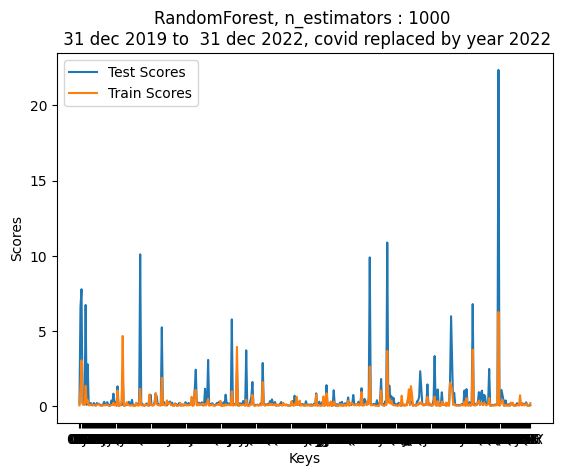

<Figure size 640x480 with 0 Axes>

In [ ]:
subtitle = '31 dec 2019 to  31 dec 2022, covid replaced by year 2022'
fig_name = '2019_2022_cov_replaced'
regressor.plot_scores(subtitle, fig_name)

In [ ]:
test_data = pd.read_csv('data/test_data_day_typed_cov_replaced_all_features.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
#one_st_filter2 = make_station_filter(test_data, stations=['1J7'])
#test_data_one_station = test_data[one_st_filter2]

In [ ]:
result = regressor.test(test_data)
result

,index,date,week,day_name,day_numeric,station,day_type,y
0,2023-01-01_1J7,2023-01-01,52,Sunday,6,1J7,7,34.569983
1,2023-01-01_O2O,2023-01-01,52,Sunday,6,O2O,7,21.531000
2,2023-01-01_8QR,2023-01-01,52,Sunday,6,8QR,7,23.946000
3,2023-01-01_L58,2023-01-01,52,Sunday,6,L58,7,5.410000
4,2023-01-01_UMC,2023-01-01,52,Sunday,6,UMC,7,42.205000
...,...,...,...,...,...,...,...,...
78647,2023-05-31_N9K,2023-05-31,22,Wednesday,2,N9K,0,1101.536000
78648,2023-05-31_P6E,2023-05-31,22,Wednesday,2,P6E,0,17.941000
78649,2023-05-31_BDC,2023-05-31,22,Wednesday,2,BDC,0,15.771000
78650,2023-05-31_QD6,2023-05-31,22,Wednesday,2,QD6,0,106.603000


In [ ]:
regressor.save_submission(name = 'RandomForest1')

In [ ]:
regressor.submission

,index,y
0,2023-01-01_1J7,34.569983
1,2023-01-01_O2O,21.531000
2,2023-01-01_8QR,23.946000
3,2023-01-01_L58,5.410000
4,2023-01-01_UMC,42.205000
...,...,...
78647,2023-05-31_N9K,1101.536000
78648,2023-05-31_P6E,17.941000
78649,2023-05-31_BDC,15.771000
78650,2023-05-31_QD6,106.603000


In [ ]:
regressor.submission

,index,y
0,2023-01-01_1J7,34.384833
1,2023-01-01_O2O,21.483000
2,2023-01-01_8QR,23.861000
3,2023-01-01_L58,5.405000
4,2023-01-01_UMC,42.162000
...,...,...
78647,2023-05-31_N9K,1100.430000
78648,2023-05-31_P6E,16.369000
78649,2023-05-31_BDC,15.155000
78650,2023-05-31_QD6,105.322000
